In [2]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [1]:
from google.colab import drive
drive.mount('/mnt/drive')

Mounted at /mnt/drive


In [2]:
def read_train_txt(train_txt_path):
    with open(train_txt_path, 'r') as file:
        image_paths = file.readlines()
    return [path.strip() for path in image_paths]

# Define path
train_txt_path = '/mnt/drive/MyDrive/ColabNotebooks/UC_Dataset/yoloframe/train.txt'

# Read image paths
image_paths = read_train_txt(train_txt_path)
print("Image paths:", image_paths[:5])  # Print first 5 paths to verify

Image paths: ['data/obj_train_data/frames/frame_0059.jpg', 'data/obj_train_data/frames/frame_0079.jpg', 'data/obj_train_data/frames/frame_0080.jpg', 'data/obj_train_data/frames/frame_0083.jpg', 'data/obj_train_data/frames/frame_0130.jpg']


In [4]:
def parse_annotation_file(annotation_path):
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
    boxes = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Define path for a sample annotation file
sample_annotation_path = '/mnt/drive/MyDrive/ColabNotebooks/UC_Dataset/yoloframe/obj_train_data/frames/frame_0059.txt'

# Parse the sample annotation file
boxes = parse_annotation_file(sample_annotation_path)
print("Parsed boxes:", boxes)


Parsed boxes: [(2, 0.518453, 0.508813, 0.153344, 0.246208)]


In [5]:
import cv2
import numpy as np
import os

def extract_features(image, boxes):
    features = []
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        h, w, _ = image.shape
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)
        roi = image[y1:y2, x1:x2]  # Extract region of interest
        if roi.size == 0:  # If ROI is empty
            continue
        # Example feature: color histogram
        hist = cv2.calcHist([roi], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
        features.append((hist, class_id))
    return features

# Define path for a sample image
sample_image_path = '/mnt/drive/MyDrive/ColabNotebooks/UC_Dataset/yoloframe/frames/frame_0059.jpg'

# Read the sample image
image = cv2.imread(sample_image_path)

# Extract features from the image
image_features = extract_features(image, boxes)
print("Extracted features:", image_features[:2])  # Print first 2 features to verify


Extracted features: [(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., 389.,  86.,   0.,   0.,
         0.,   0.,   0.,   0.,  42., 226.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,  88.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,  35., 786.

In [6]:
frames_dir = '/mnt/drive/MyDrive/ColabNotebooks/UC_Dataset/yoloframe/frames'
annotations_dir = '/mnt/drive/MyDrive/ColabNotebooks/UC_Dataset/yoloframe/obj_train_data/frames'

features = []
labels = []

for image_path in image_paths:
    image_full_path = os.path.join(frames_dir, os.path.basename(image_path))
    annotation_path = os.path.join(annotations_dir, os.path.splitext(os.path.basename(image_path))[0] + '.txt')

    if not os.path.exists(image_full_path) or not os.path.exists(annotation_path):
        continue

    image = cv2.imread(image_full_path)
    boxes = parse_annotation_file(annotation_path)
    image_features = extract_features(image, boxes)

    for hist, class_id in image_features:
        features.append(hist)
        labels.append(class_id)

X = np.array(features)
y = np.array(labels)

print("Dataset shapes:", X.shape, y.shape)


Dataset shapes: (146, 512) (146,)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming X and y are defined
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Models
knn = KNeighborsClassifier()
svm = SVC(probability=True)
dt = DecisionTreeClassifier()

knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
dt.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Check if model has predict_proba
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = None

    cm = confusion_matrix(y_test, y_pred)

    # Compute ROC AUC
    if y_proba is not None:
        if len(np.unique(y_test)) == 2:  # Binary classification
            auc = roc_auc_score(y_test, y_proba[:, 1])
        else:  # Multi-class classification
            auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        auc = None

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return cm, auc, precision, recall, f1

# Evaluate Models
knn_results = evaluate_model(knn, X_test, y_test)
svm_results = evaluate_model(svm, X_test, y_test)
dt_results = evaluate_model(dt, X_test, y_test)

print(f"KNN Results: {knn_results}")
print(f"SVM Results: {svm_results}")
print(f"Decision Tree Results: {dt_results}")


KNN Results: (array([[ 4,  1,  3],
       [ 0, 16,  0],
       [ 1,  1,  4]]), 0.8587662337662337, 0.8016931216931216, 0.8, 0.7891402714932128)
SVM Results: (array([[ 0,  4,  4],
       [ 0, 16,  0],
       [ 0,  2,  4]]), 0.9221079846079846, 0.4878787878787879, 0.6666666666666666, 0.5634085213032581)
Decision Tree Results: (array([[ 4,  2,  2],
       [ 1, 15,  0],
       [ 0,  0,  6]]), 0.8609758297258298, 0.8339215686274509, 0.8333333333333334, 0.8203796203796203)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[
    ('knn', knn),
    ('svm', svm),
    ('dt', dt)
], voting='soft')

ensemble_model.fit(X_train, y_train)
ensemble_results = evaluate_model(ensemble_model, X_test, y_test)
print(f"Ensemble Model Results: {ensemble_results}")


Ensemble Model Results: (array([[ 4,  2,  2],
       [ 1, 15,  0],
       [ 0,  1,  5]]), 0.9401755651755651, 0.8006349206349206, 0.8, 0.7885369532428357)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Models
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=300)
}

# Train Models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Check if model has predict_proba
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = None

    cm = confusion_matrix(y_test, y_pred)

    # Compute ROC AUC
    if y_proba is not None:
        if len(np.unique(y_test)) == 2:  # Binary classification
            auc = roc_auc_score(y_test, y_proba[:, 1])
        else:  # Multi-class classification
            auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        auc = None

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return cm, auc, precision, recall, f1

# Evaluate Models
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_test, y_test)
    print(f"{name} Results: {results[name]}")

print("Evaluation complete.")


Random Forest trained.
Gradient Boosting trained.
AdaBoost trained.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression trained.
Naive Bayes trained.
Neural Network trained.
Random Forest Results: (array([[ 2,  2,  4],
       [ 0, 16,  0],
       [ 0,  1,  5]]), 0.9300895863395864, 0.8269005847953216, 0.7666666666666667, 0.7276190476190476)
Gradient Boosting Results: (array([[ 2,  2,  4],
       [ 0, 16,  0],
       [ 0,  0,  6]]), 0.9566197691197692, 0.8607407407407408, 0.8, 0.7586274509803921)
AdaBoost Results: (array([[ 2,  0,  6],
       [ 5, 11,  0],
       [ 3,  0,  3]]), 0.816017316017316, 0.6533333333333334, 0.5333333333333333, 0.5738271604938272)
Logistic Regression Results: (array([[ 5,  2,  1],
       [ 0, 16,  0],
       [ 3,  2,  1]]), 0.8722643097643097, 0.6933333333333334, 0.7333333333333333, 0.6907407407407408)
Naive Bayes Results: (array([[ 2,  0,  6],
       [ 0, 13,  3],
       [ 0,  0,  6]]), 0.8831619769119768, 0.88, 0.7, 0.6991133004926108)
Neural Network Results: (array([[ 5,  2,  1],
       [ 1, 14,  1],
       [ 1,  2,  3]]), 0.86371151996152, 0.7252910052910

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Assuming X and y are defined
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Models
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=300)
}

# Train Models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Check if model has predict_proba
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = None

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Compute ROC AUC
    if y_proba is not None:
        if len(np.unique(y_test)) == 2:  # Binary classification
            auc = roc_auc_score(y_test, y_proba[:, 1])
        else:  # Multi-class classification
            auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        auc = None

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, auc, precision, recall, f1

# Evaluate Models and collect results
results = []
for name, model in models.items():
    accuracy, auc, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    print(f"{name} Results: Accuracy={accuracy}, ROC AUC={auc}, Precision={precision}, Recall={recall}, F1 Score={f1}")

# Create DataFrame to summarize results
results_df = pd.DataFrame(results)
print(results_df)


KNN trained.
SVM trained.
Decision Tree trained.
Random Forest trained.
Gradient Boosting trained.
AdaBoost trained.
Logistic Regression trained.
Naive Bayes trained.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Neural Network trained.
KNN Results: Accuracy=0.8, ROC AUC=0.8587662337662337, Precision=0.8016931216931216, Recall=0.8, F1 Score=0.7891402714932128
SVM Results: Accuracy=0.6666666666666666, ROC AUC=0.9221079846079846, Precision=0.4878787878787879, Recall=0.6666666666666666, F1 Score=0.5634085213032581
Decision Tree Results: Accuracy=0.7666666666666667, ROC AUC=0.8082611832611833, Precision=0.7694444444444444, Recall=0.7666666666666667, F1 Score=0.761904761904762
Random Forest Results: Accuracy=0.8, ROC AUC=0.9280002405002405, Precision=0.8518518518518517, Recall=0.8, F1 Score=0.7807486631016043
Gradient Boosting Results: Accuracy=0.8, ROC AUC=0.9547258297258298, Precision=0.8607407407407408, Recall=0.8, F1 Score=0.7586274509803921
AdaBoost Results: Accuracy=0.5333333333333333, ROC AUC=0.816017316017316, Precision=0.6533333333333334, Recall=0.5333333333333333, F1 Score=0.5738271604938272
Logistic Regression Results: Accuracy=0.7333333333333333, ROC AUC=0.8722643097643097, Precision=0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Assuming X and y are defined
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Models
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=300)
}

# Train Models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Check if model has predict_proba
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = None

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Compute ROC AUC
    if y_proba is not None:
        if len(np.unique(y_test)) == 2:  # Binary classification
            auc = roc_auc_score(y_test, y_proba[:, 1])
        else:  # Multi-class classification
            auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        auc = None

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, auc, precision, recall, f1

# Evaluate Models and collect results
results = []
for name, model in models.items():
    accuracy, auc, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    print(f"{name} Results: Accuracy={accuracy}, ROC AUC={auc}, Precision={precision}, Recall={recall}, F1 Score={f1}")

# Ensemble Model
ensemble_model = VotingClassifier(estimators=[
    ('knn', models['KNN']),
    ('svm', models['SVM']),
    ('dt', models['Decision Tree'])
], voting='soft')

ensemble_model.fit(X_train, y_train)
ensemble_accuracy, ensemble_auc, ensemble_precision, ensemble_recall, ensemble_f1 = evaluate_model(ensemble_model, X_test, y_test)
print(f"Ensemble Model Results: Accuracy={ensemble_accuracy}, ROC AUC={ensemble_auc}, Precision={ensemble_precision}, Recall={ensemble_recall}, F1 Score={ensemble_f1}")

# Add ensemble results to the table
results.append({
    'Model': 'Ensemble',
    'Accuracy': ensemble_accuracy,
    'ROC AUC': ensemble_auc,
    'Precision': ensemble_precision,
    'Recall': ensemble_recall,
    'F1 Score': ensemble_f1
})

# Create DataFrame to summarize results
results_df = pd.DataFrame(results)
print(results_df)


KNN trained.
SVM trained.
Decision Tree trained.
Random Forest trained.
Gradient Boosting trained.
AdaBoost trained.
Logistic Regression trained.
Naive Bayes trained.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Neural Network trained.
KNN Results: Accuracy=0.8, ROC AUC=0.8587662337662337, Precision=0.8016931216931216, Recall=0.8, F1 Score=0.7891402714932128
SVM Results: Accuracy=0.6666666666666666, ROC AUC=0.9221079846079846, Precision=0.4878787878787879, Recall=0.6666666666666666, F1 Score=0.5634085213032581
Decision Tree Results: Accuracy=0.8333333333333334, ROC AUC=0.8609758297258298, Precision=0.8339215686274509, Recall=0.8333333333333334, F1 Score=0.8203796203796203
Random Forest Results: Accuracy=0.8333333333333334, ROC AUC=0.9551467051467051, Precision=0.8886274509803921, Recall=0.8333333333333334, F1 Score=0.8126262626262626
Gradient Boosting Results: Accuracy=0.8, ROC AUC=0.9505170755170754, Precision=0.8607407407407408, Recall=0.8, F1 Score=0.7586274509803921
AdaBoost Results: Accuracy=0.5333333333333333, ROC AUC=0.816017316017316, Precision=0.6533333333333334, Recall=0.5333333333333333, F1 Score=0.5738271604938272
Logistic Regression Results: Accuracy=0.7333333333333333, ROC AUC=0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Assuming X and y are defined
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Models
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=300)
}

# Train Models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Check if model has predict_proba
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = None

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Compute ROC AUC
    if y_proba is not None:
        if len(np.unique(y_test)) == 2:  # Binary classification
            auc = roc_auc_score(y_test, y_proba[:, 1])
        else:  # Multi-class classification
            auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        auc = None

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, auc, precision, recall, f1

# Evaluate Models and collect results
results = []
for name, model in models.items():
    accuracy, auc, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    print(f"{name} Results: Accuracy={accuracy}, ROC AUC={auc}, Precision={precision}, Recall={recall}, F1 Score={f1}")

# Define Ensembles
ensembles = {
    'Ensemble 1': VotingClassifier(estimators=[
        ('knn', models['KNN']),
        ('svm', models['SVM']),
        ('dt', models['Decision Tree'])
    ], voting='soft'),
    'Ensemble 2': VotingClassifier(estimators=[
        ('rf', models['Random Forest']),
        ('gb', models['Gradient Boosting']),
        ('adb', models['AdaBoost'])
    ], voting='soft'),
    'Ensemble 3': VotingClassifier(estimators=[
        ('lr', models['Logistic Regression']),
        ('nb', models['Naive Bayes']),
        ('nn', models['Neural Network'])
    ], voting='soft')
}

# Train and Evaluate Ensembles
for name, ensemble in ensembles.items():
    ensemble.fit(X_train, y_train)
    accuracy, auc, precision, recall, f1 = evaluate_model(ensemble, X_test, y_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    print(f"{name} Results: Accuracy={accuracy}, ROC AUC={auc}, Precision={precision}, Recall={recall}, F1 Score={f1}")

# Create DataFrame to summarize results
results_df = pd.DataFrame(results)
print(results_df)


KNN trained.
SVM trained.
Decision Tree trained.
Random Forest trained.
Gradient Boosting trained.
AdaBoost trained.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression trained.
Naive Bayes trained.
Neural Network trained.
KNN Results: Accuracy=0.8, ROC AUC=0.8587662337662337, Precision=0.8016931216931216, Recall=0.8, F1 Score=0.7891402714932128
SVM Results: Accuracy=0.6666666666666666, ROC AUC=0.919808201058201, Precision=0.4878787878787879, Recall=0.6666666666666666, F1 Score=0.5634085213032581
Decision Tree Results: Accuracy=0.7333333333333333, ROC AUC=0.7761544011544012, Precision=0.7503267973856208, Recall=0.7333333333333333, F1 Score=0.7191919191919193


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Results: Accuracy=0.8, ROC AUC=0.9257756132756133, Precision=0.8518518518518517, Recall=0.8, F1 Score=0.7807486631016043
Gradient Boosting Results: Accuracy=0.8, ROC AUC=0.9566197691197692, Precision=0.8607407407407408, Recall=0.8, F1 Score=0.7586274509803921
AdaBoost Results: Accuracy=0.5333333333333333, ROC AUC=0.816017316017316, Precision=0.6533333333333334, Recall=0.5333333333333333, F1 Score=0.5738271604938272
Logistic Regression Results: Accuracy=0.7333333333333333, ROC AUC=0.8722643097643097, Precision=0.6933333333333334, Recall=0.7333333333333333, F1 Score=0.6907407407407408
Naive Bayes Results: Accuracy=0.7, ROC AUC=0.8831619769119768, Precision=0.88, Recall=0.7, F1 Score=0.6991133004926108
Neural Network Results: Accuracy=0.8333333333333334, ROC AUC=0.8312590187590186, Precision=0.8444444444444446, Recall=0.8333333333333334, F1 Score=0.8324929971988796
Ensemble 1 Results: Accuracy=0.8666666666666667, ROC AUC=0.9475408850408851, Precision=0.8642390289449113, Reca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble 3 Results: Accuracy=0.8333333333333334, ROC AUC=0.9485930735930737, Precision=0.853968253968254, Recall=0.8333333333333334, F1 Score=0.8295625942684766
                  Model  Accuracy   ROC AUC  Precision    Recall  F1 Score
0                   KNN  0.800000  0.858766   0.801693  0.800000  0.789140
1                   SVM  0.666667  0.919808   0.487879  0.666667  0.563409
2         Decision Tree  0.733333  0.776154   0.750327  0.733333  0.719192
3         Random Forest  0.800000  0.925776   0.851852  0.800000  0.780749
4     Gradient Boosting  0.800000  0.956620   0.860741  0.800000  0.758627
5              AdaBoost  0.533333  0.816017   0.653333  0.533333  0.573827
6   Logistic Regression  0.733333  0.872264   0.693333  0.733333  0.690741
7           Naive Bayes  0.700000  0.883162   0.880000  0.700000  0.699113
8        Neural Network  0.833333  0.831259   0.844444  0.833333  0.832493
9            Ensemble 1  0.866667  0.947541   0.864239  0.866667  0.859940
10           E

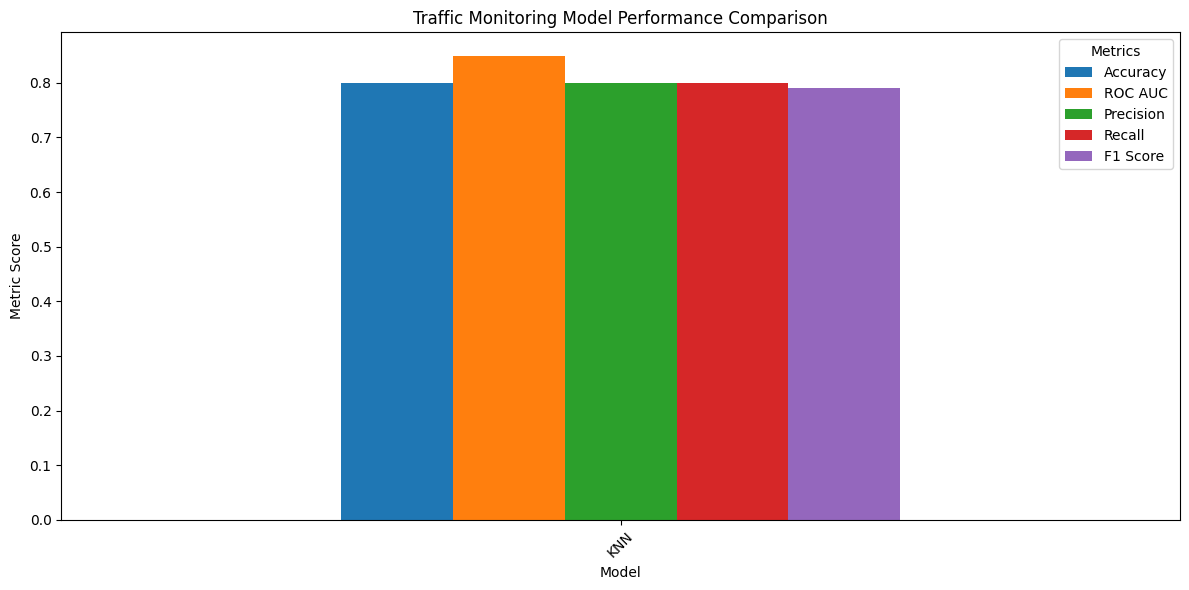

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'results' is a list of dictionaries containing your model results
results = [
    {'Model': 'KNN', 'Accuracy': 0.8, 'ROC AUC': 0.85, 'Precision': 0.8, 'Recall': 0.8, 'F1 Score': 0.79},
    # ... add other model results here
]

# Create DataFrame to summarize results
results_df = pd.DataFrame(results)

# Create the bar chart
results_df.plot(x='Model', y=['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1 Score'], kind='bar', figsize=(12, 6))
plt.title('Traffic Monitoring Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Metric Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

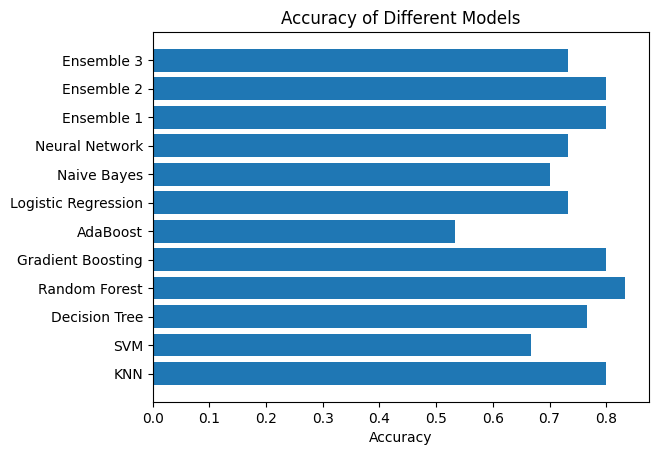

In [14]:
model_names = ['KNN', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'AdaBoost', 'Logistic Regression', 'Naive Bayes', 'Neural Network', 'Ensemble 1', 'Ensemble 2', 'Ensemble 3']
accuracies = [0.800000, 0.666667, 0.766667, 0.833333, 0.800000, 0.533333, 0.733333, 0.700000, 0.733333, 0.800000, 0.800000, 0.733333]

plt.barh(model_names, accuracies)
plt.xlabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.show()


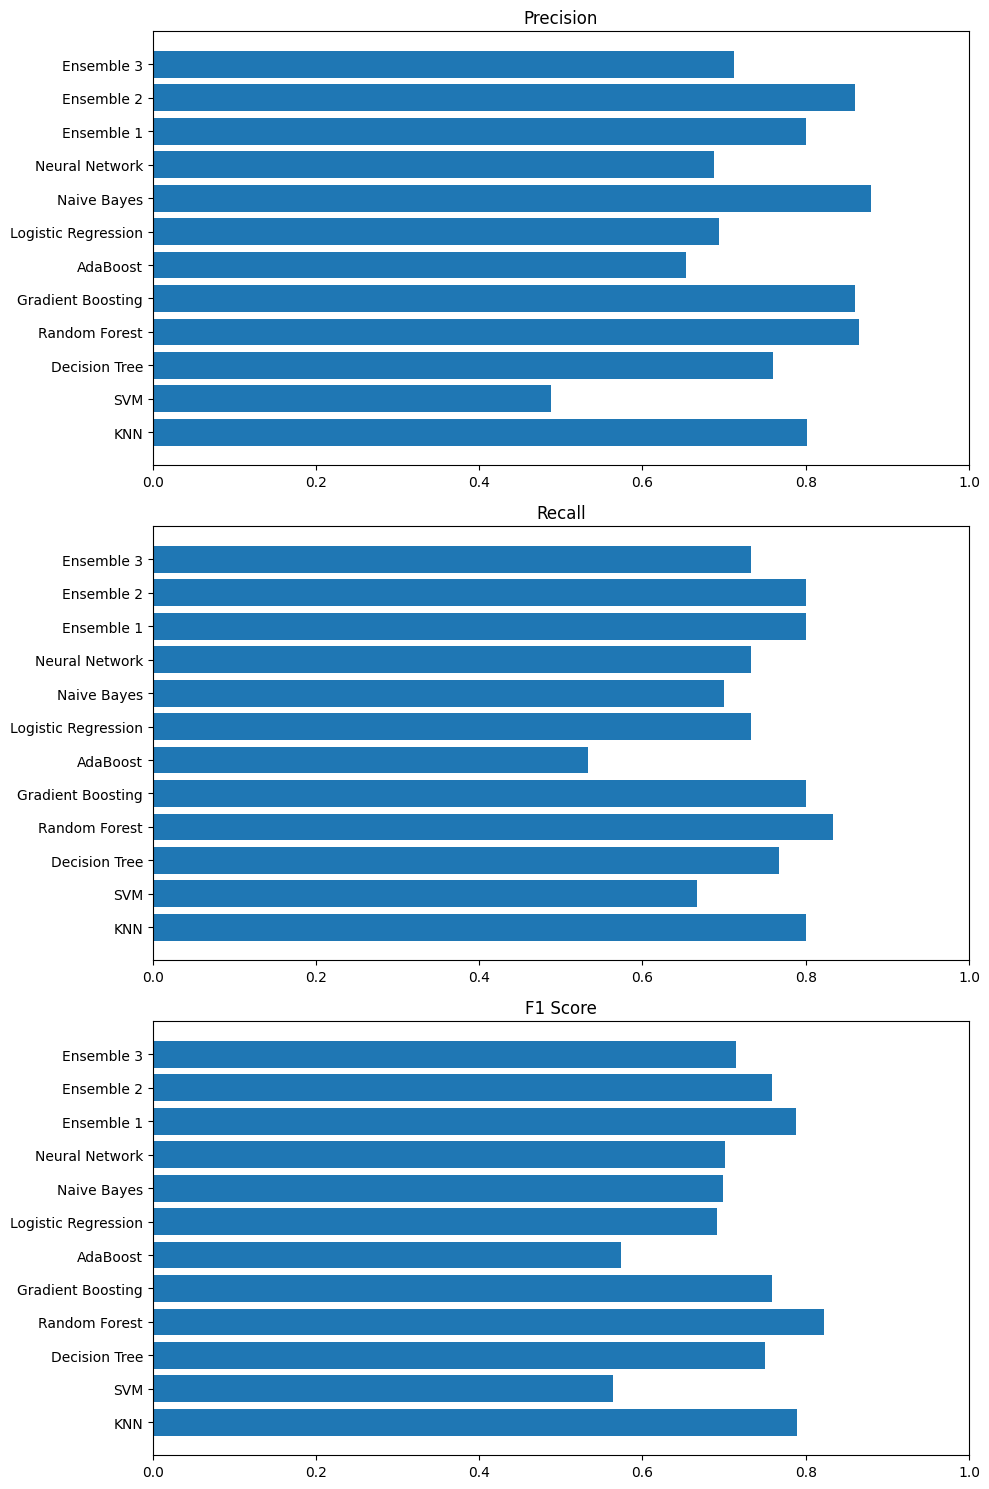

In [15]:
metrics = ['Precision', 'Recall', 'F1 Score']
model_metrics = {
    'KNN': [0.801693, 0.800000, 0.789140],
    'SVM': [0.487879, 0.666667, 0.563409],
    'Decision Tree': [0.760000, 0.766667, 0.749744],
    'Random Forest': [0.865741, 0.833333, 0.822596],
    'Gradient Boosting': [0.860741, 0.800000, 0.758627],
    'AdaBoost': [0.653333, 0.533333, 0.573827],
    'Logistic Regression': [0.693333, 0.733333, 0.690741],
    'Naive Bayes': [0.880000, 0.700000, 0.699113],
    'Neural Network': [0.687719, 0.733333, 0.701587],
    'Ensemble 1': [0.800635, 0.800000, 0.788537],
    'Ensemble 2': [0.860741, 0.800000, 0.758627],
    'Ensemble 3': [0.711529, 0.733333, 0.714921]
}

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
for i, metric in enumerate(metrics):
    values = [model_metrics[model][i] for model in model_metrics]
    ax[i].barh(model_names, values)
    ax[i].set_title(metric)
    ax[i].set_xlim([0, 1])

plt.tight_layout()
plt.show()


In [19]:
def read_train_txt(train_txt_path):
    with open(train_txt_path, 'r') as file:
        image_paths = file.readlines()
    return [path.strip() for path in image_paths]

def parse_annotation_file(annotation_path):
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
    boxes = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

import cv2
import numpy as np
import os

def extract_features(image, boxes):
    features = []
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        h, w, _ = image.shape
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)
        roi = image[y1:y2, x1:x2]  # Extract region of interest
        if roi.size == 0:  # If ROI is empty
            continue
        # Example feature: color histogram
        hist = cv2.calcHist([roi], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
        features.append((hist, class_id))
    return features

# Paths to your dataset
train_txt_path = '/mnt/drive/MyDrive/ColabNotebooks/UC_Dataset/yoloframe/train.txt'
frames_dir = '/mnt/drive/MyDrive/ColabNotebooks/UC_Dataset/yoloframe/frames'
annotations_dir = '/mnt/drive/MyDrive/ColabNotebooks/UC_Dataset/yoloframe/obj_train_data/frames'

# Read image paths
image_paths = read_train_txt(train_txt_path)

features = []
labels = []

for image_path in image_paths:
    image_full_path = os.path.join(frames_dir, os.path.basename(image_path))
    annotation_path = os.path.join(annotations_dir, os.path.splitext(os.path.basename(image_path))[0] + '.txt')

    if not os.path.exists(image_full_path) or not os.path.exists(annotation_path):
        continue

    image = cv2.imread(image_full_path)
    boxes = parse_annotation_file(annotation_path)
    image_features = extract_features(image, boxes)

    for hist, class_id in image_features:
        features.append(hist)
        labels.append(class_id)

X = np.array(features)
y = np.array(labels)

print("Dataset shapes:", X.shape, y.shape)


Dataset shapes: (146, 512) (146,)


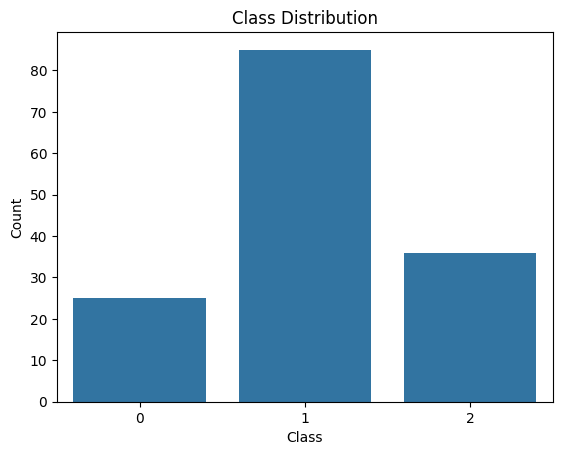

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


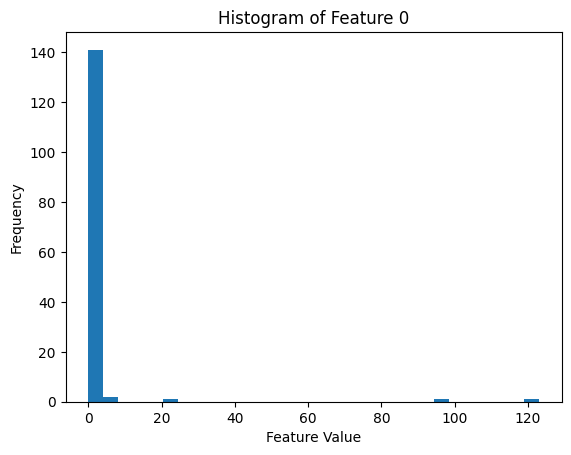

In [21]:
feature_index = 0  # Change this to any feature index you want to visualize
plt.hist(X[:, feature_index], bins=30)
plt.title(f'Histogram of Feature {feature_index}')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.show()


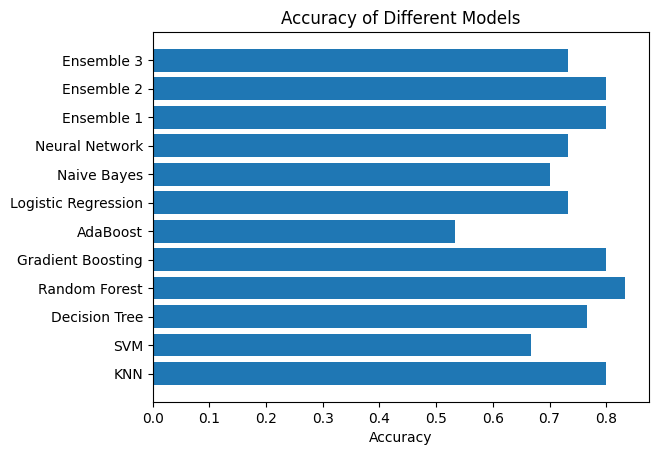

In [23]:
model_names = ['KNN', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'AdaBoost', 'Logistic Regression', 'Naive Bayes', 'Neural Network', 'Ensemble 1', 'Ensemble 2', 'Ensemble 3']
accuracies = [0.800000, 0.666667, 0.766667, 0.833333, 0.800000, 0.533333, 0.733333, 0.700000, 0.733333, 0.800000, 0.800000, 0.733333]

plt.barh(model_names, accuracies)
plt.xlabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.show()


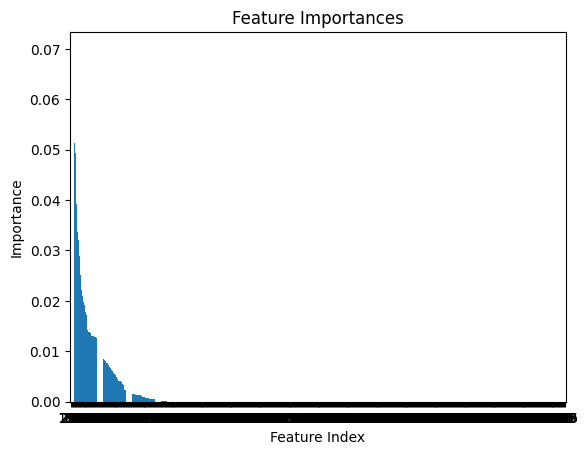

In [36]:
import numpy as np

importances = models['Random Forest'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()


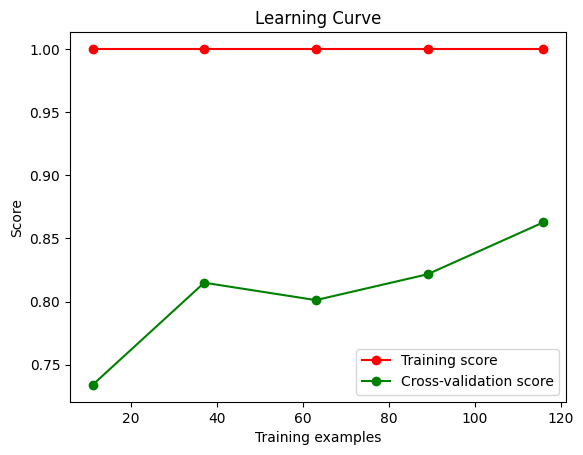

In [38]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(models['Random Forest'], X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


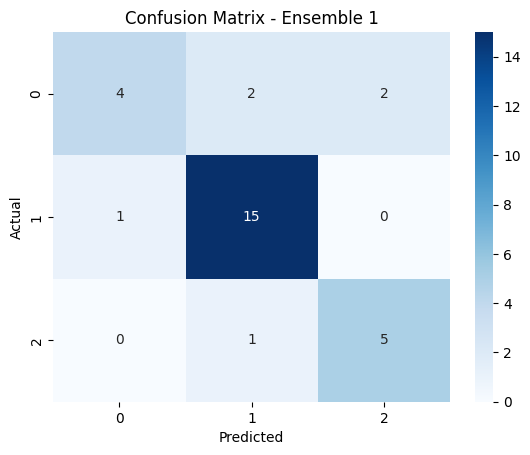

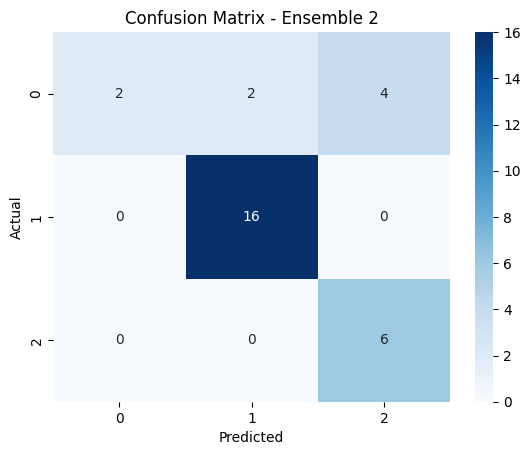

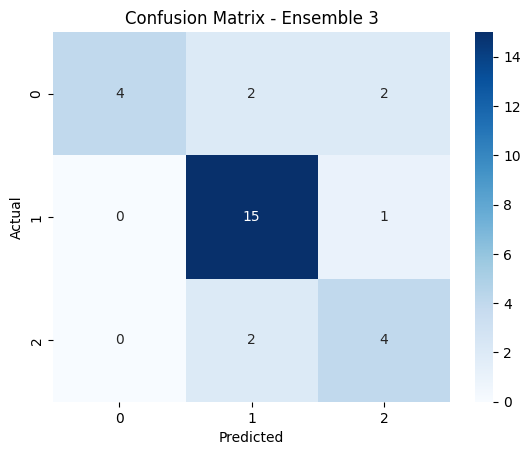

In [43]:
for ensemble_name, ensemble in ensembles.items():
    plot_confusion_matrix(y_test, ensemble.predict(X_test), ensemble_name)


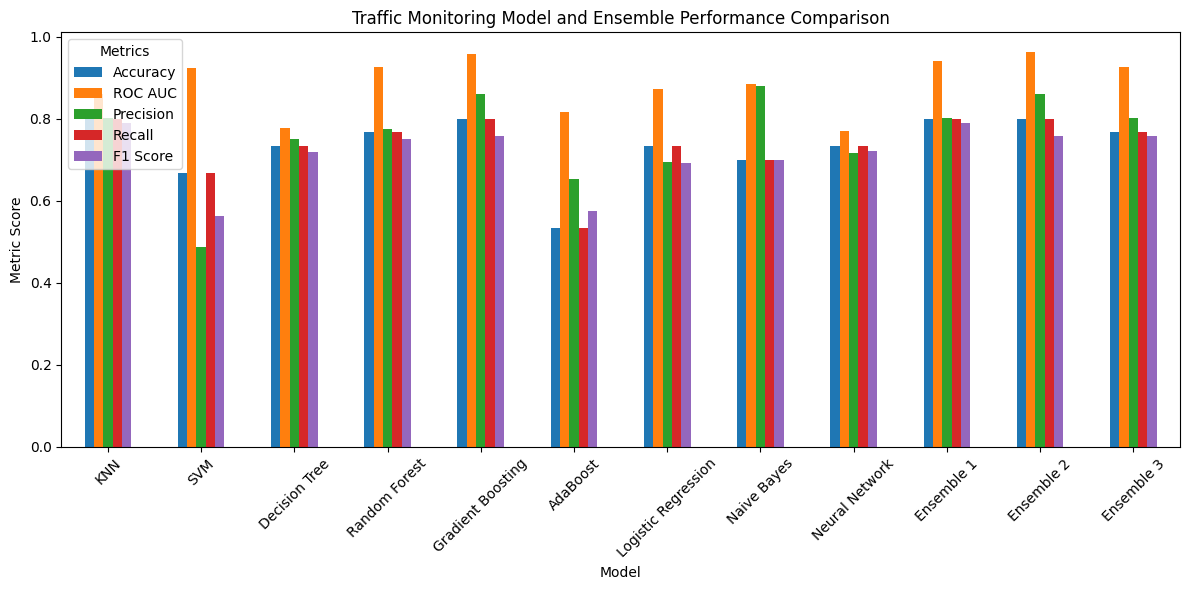

In [45]:
results_df.plot(x='Model', y=['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1 Score'], kind='bar', figsize=(12, 6))
plt.title('Traffic Monitoring Model and Ensemble Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Metric Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:492: RuntimeWarning: invalid value encountered in divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Skipping Decision Tree due to NaN values in predictions.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Skipping Naive Bayes due to NaN values in predictions.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

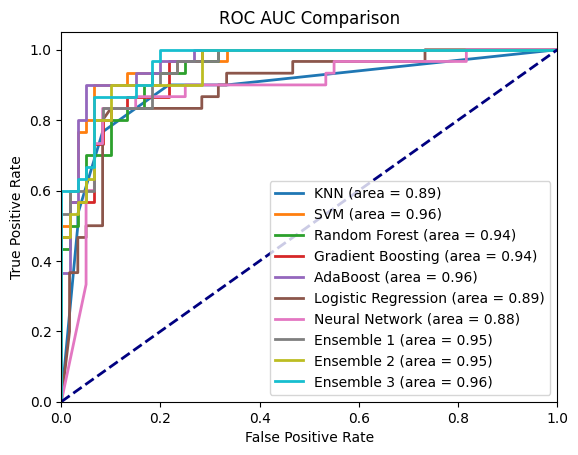

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

def plot_roc_curve(y_test_binarized, y_score, model_name):
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')

plt.figure()

# Plot ROC curves for individual models
for model_name, model in models.items():
    if hasattr(model, 'predict_proba'):
        classifier = OneVsRestClassifier(model)
        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
        if np.isnan(y_score).any():
            print(f"Skipping {model_name} due to NaN values in predictions.")
            continue
        plot_roc_curve(y_test_binarized, y_score, model_name)

# Plot ROC curves for ensemble models
for ensemble_name, ensemble in ensembles.items():
    if hasattr(ensemble, 'predict_proba'):
        classifier = OneVsRestClassifier(ensemble)
        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
        if np.isnan(y_score).any():
            print(f"Skipping {ensemble_name} due to NaN values in predictions.")
            continue
        plot_roc_curve(y_test_binarized, y_score, ensemble_name)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Comparison')
plt.legend(loc="lower right")
plt.show()


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Assuming X and y are defined
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Models
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=300)
}

# Train Models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Check if model has predict_proba
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = None

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Compute ROC AUC
    if y_proba is not None:
        if len(np.unique(y_test)) == 2:  # Binary classification
            auc = roc_auc_score(y_test, y_proba[:, 1])
        else:  # Multi-class classification
            auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        auc = None

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, auc, precision, recall, f1

# Evaluate Models and collect results
results = []
for name, model in models.items():
    accuracy, auc, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    print(f"{name} Results: Accuracy={accuracy}, ROC AUC={auc}, Precision={precision}, Recall={recall}, F1 Score={f1}")

# Define Ensembles
ensembles = {
    'Ensemble 1': VotingClassifier(estimators=[
        ('knn', models['KNN']),
        ('svm', models['SVM']),
        ('dt', models['Decision Tree'])
    ], voting='soft'),
    'Ensemble 2': VotingClassifier(estimators=[
        ('rf', models['Random Forest']),
        ('gb', models['Gradient Boosting']),
        ('adb', models['AdaBoost'])
    ], voting='soft'),
    'Ensemble 3': VotingClassifier(estimators=[
        ('lr', models['Logistic Regression']),
        ('nb', models['Naive Bayes']),
        ('nn', models['Neural Network'])
    ], voting='soft')
}

# Train and Evaluate Ensembles
for name, ensemble in ensembles.items():
    ensemble.fit(X_train, y_train)
    accuracy, auc, precision, recall, f1 = evaluate_model(ensemble, X_test, y_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    print(f"{name} Results: Accuracy={accuracy}, ROC AUC={auc}, Precision={precision}, Recall={recall}, F1 Score={f1}")

# Create DataFrame to summarize results
results_df = pd.DataFrame(results)
print(results_df)


KNN trained.
SVM trained.
Decision Tree trained.
Random Forest trained.
Gradient Boosting trained.
AdaBoost trained.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression trained.
Naive Bayes trained.
Neural Network trained.
KNN Results: Accuracy=0.8, ROC AUC=0.8587662337662337, Precision=0.8016931216931216, Recall=0.8, F1 Score=0.7891402714932128
SVM Results: Accuracy=0.6666666666666666, ROC AUC=0.9244227994227995, Precision=0.4878787878787879, Recall=0.6666666666666666, F1 Score=0.5634085213032581
Decision Tree Results: Accuracy=0.8, ROC AUC=0.8429834054834053, Precision=0.7944444444444444, Recall=0.8, F1 Score=0.7904761904761906


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Results: Accuracy=0.7666666666666667, ROC AUC=0.9293831168831169, Precision=0.7629629629629628, Recall=0.7666666666666667, F1 Score=0.7322638146167558
Gradient Boosting Results: Accuracy=0.8, ROC AUC=0.9547258297258298, Precision=0.8607407407407408, Recall=0.8, F1 Score=0.7586274509803921
AdaBoost Results: Accuracy=0.5333333333333333, ROC AUC=0.816017316017316, Precision=0.6533333333333334, Recall=0.5333333333333333, F1 Score=0.5738271604938272
Logistic Regression Results: Accuracy=0.7333333333333333, ROC AUC=0.8722643097643097, Precision=0.6933333333333334, Recall=0.7333333333333333, F1 Score=0.6907407407407408
Naive Bayes Results: Accuracy=0.7, ROC AUC=0.8831619769119768, Precision=0.88, Recall=0.7, F1 Score=0.6991133004926108
Neural Network Results: Accuracy=0.7333333333333333, ROC AUC=0.791065416065416, Precision=0.7434920634920634, Recall=0.7333333333333333, F1 Score=0.726998491704374
Ensemble 1 Results: Accuracy=0.8333333333333334, ROC AUC=0.935966810966811, Precisi

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble 3 Results: Accuracy=0.8, ROC AUC=0.9381012506012506, Precision=0.8070961718020542, Recall=0.8, F1 Score=0.7984015984015983
                  Model  Accuracy   ROC AUC  Precision    Recall  F1 Score
0                   KNN  0.800000  0.858766   0.801693  0.800000  0.789140
1                   SVM  0.666667  0.924423   0.487879  0.666667  0.563409
2         Decision Tree  0.800000  0.842983   0.794444  0.800000  0.790476
3         Random Forest  0.766667  0.929383   0.762963  0.766667  0.732264
4     Gradient Boosting  0.800000  0.954726   0.860741  0.800000  0.758627
5              AdaBoost  0.533333  0.816017   0.653333  0.533333  0.573827
6   Logistic Regression  0.733333  0.872264   0.693333  0.733333  0.690741
7           Naive Bayes  0.700000  0.883162   0.880000  0.700000  0.699113
8        Neural Network  0.733333  0.791065   0.743492  0.733333  0.726998
9            Ensemble 1  0.833333  0.935967   0.827731  0.833333  0.829293
10           Ensemble 2  0.800000  0.957477

/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:492: RuntimeWarning: invalid value encountered in divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Skipping Decision Tree due to NaN values in predictions.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Skipping Naive Bayes due to NaN values in predictions.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

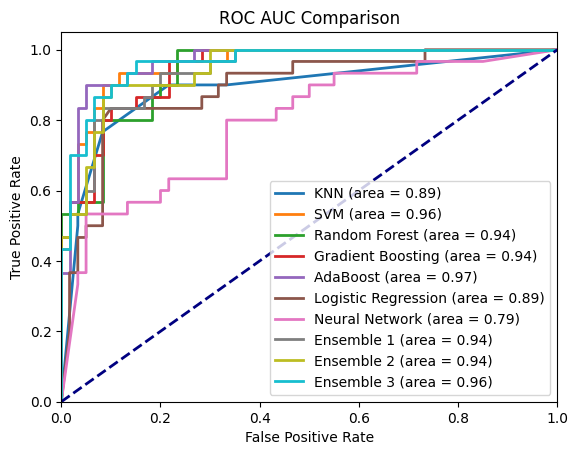

In [59]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

def plot_roc_curve(y_test_binarized, y_score, model_name):
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')

plt.figure()

# Plot ROC curves for individual models
for model_name, model in models.items():
    if hasattr(model, 'predict_proba'):
        classifier = OneVsRestClassifier(model)
        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
        if np.isnan(y_score).any():
            print(f"Skipping {model_name} due to NaN values in predictions.")
            continue
        plot_roc_curve(y_test_binarized, y_score, model_name)

# Plot ROC curves for ensemble models
for ensemble_name, ensemble in ensembles.items():
    if hasattr(ensemble, 'predict_proba'):
        classifier = OneVsRestClassifier(ensemble)
        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
        if np.isnan(y_score).any():
            print(f"Skipping {ensemble_name} due to NaN values in predictions.")
            continue
        plot_roc_curve(y_test_binarized, y_score, ensemble_name)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Comparison')
plt.legend(loc="lower right")
plt.show()


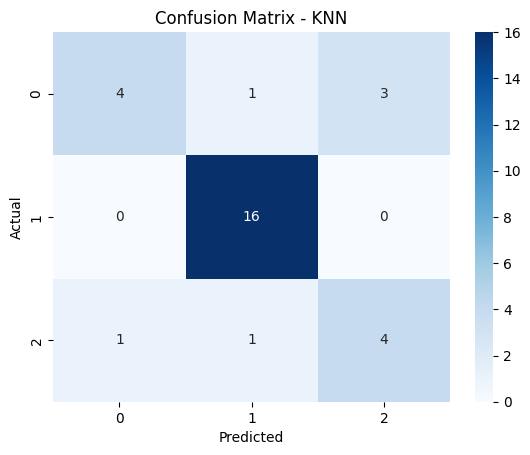

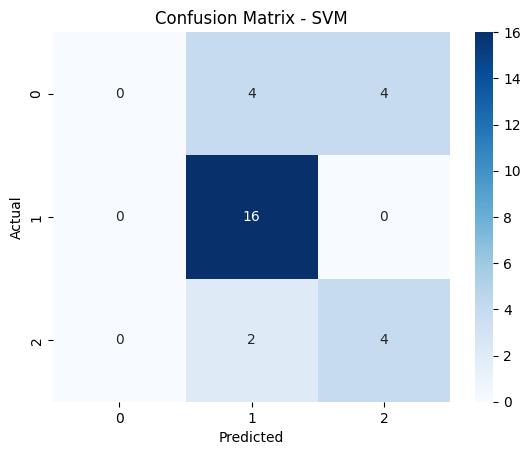

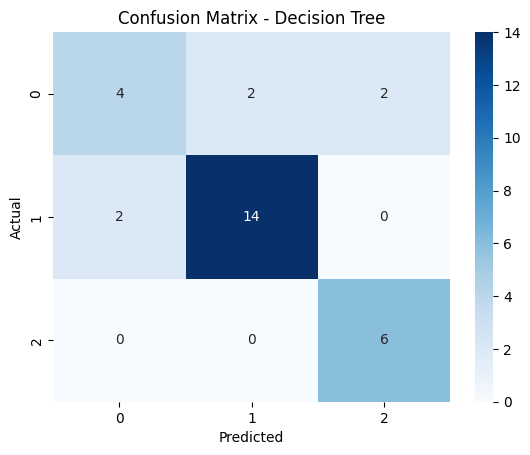

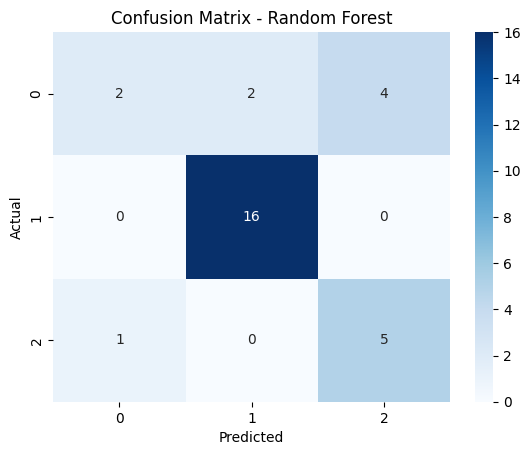

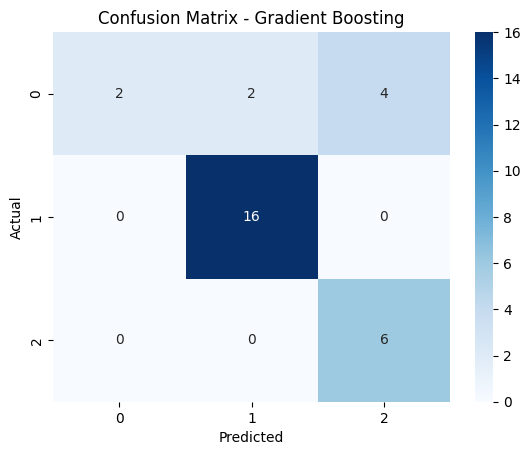

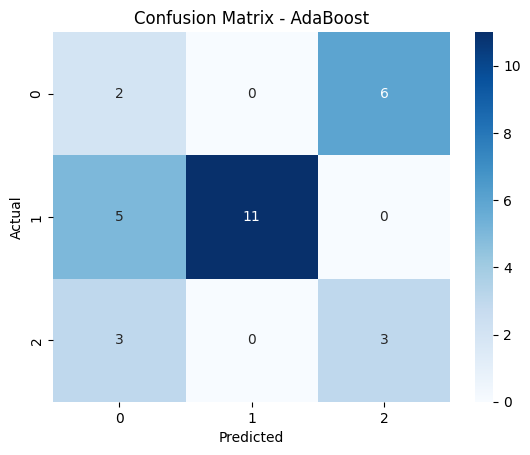

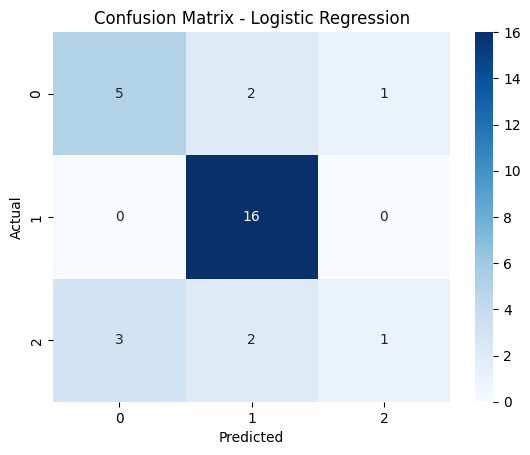

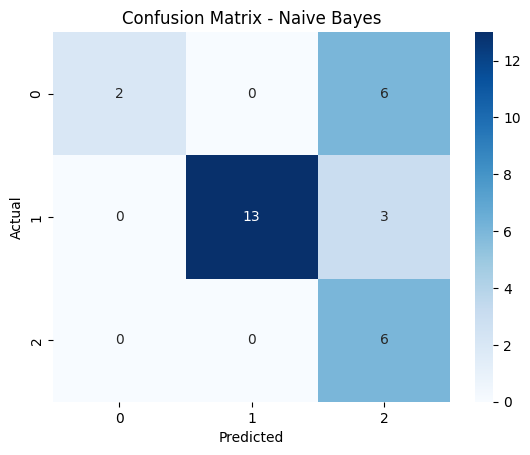

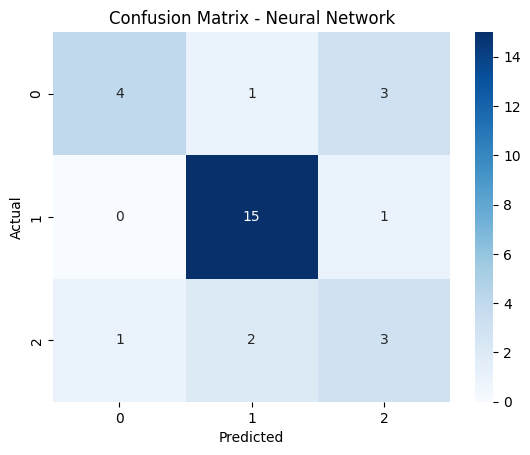

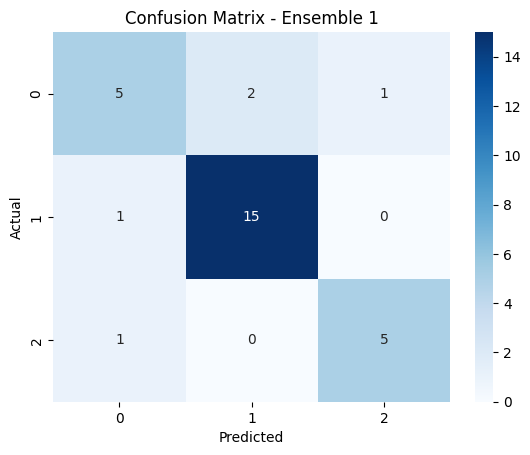

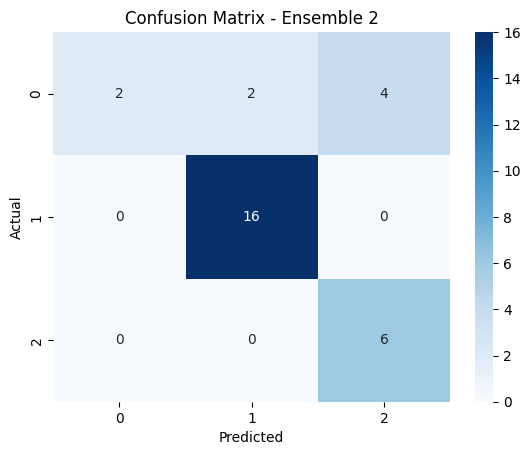

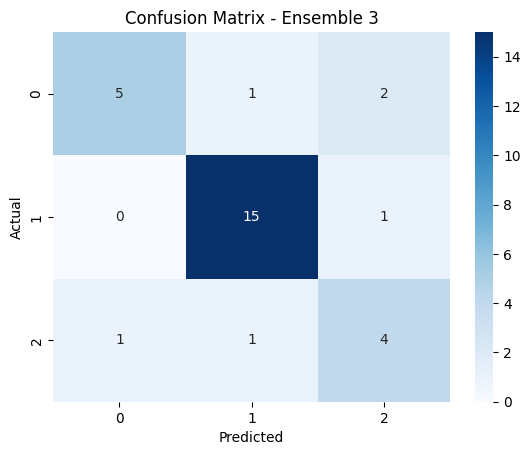

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices for individual models
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model_name)

# Plot confusion matrices for ensemble models
for ensemble_name, ensemble in ensembles.items():
    y_pred = ensemble.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, ensemble_name)


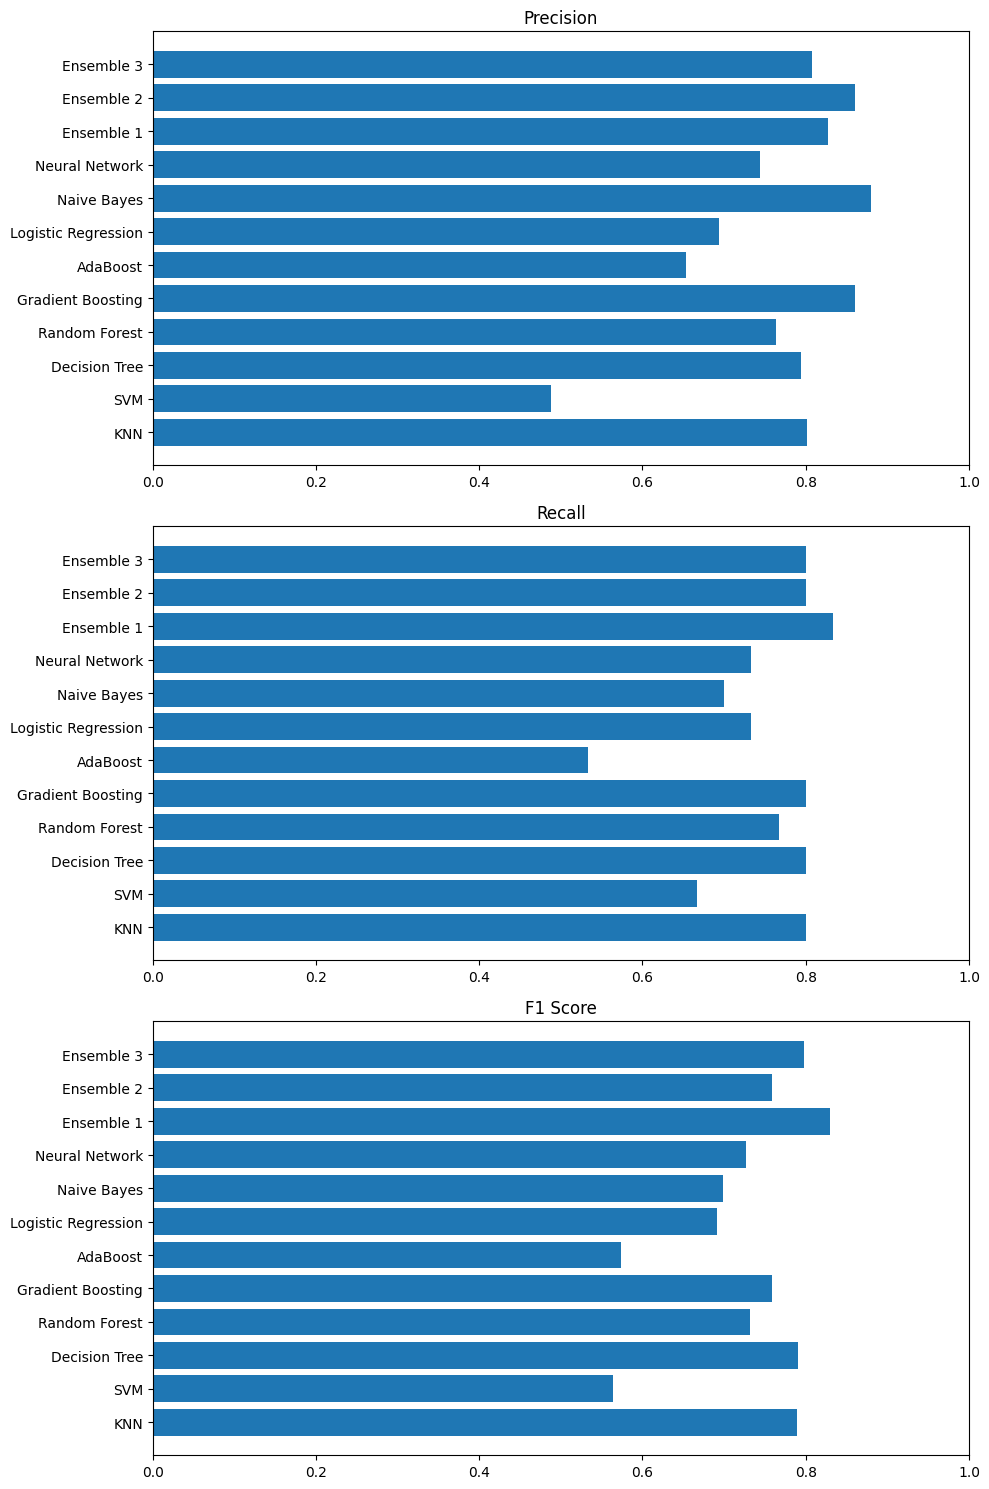

In [65]:
import matplotlib.pyplot as plt

metrics = ['Precision', 'Recall', 'F1 Score']
model_names = ['KNN', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'AdaBoost', 'Logistic Regression', 'Naive Bayes', 'Neural Network', 'Ensemble 1', 'Ensemble 2', 'Ensemble 3']

model_metrics = {
    'KNN': results_df.loc[results_df['Model'] == 'KNN'].values[0][3:6],
    'SVM': results_df.loc[results_df['Model'] == 'SVM'].values[0][3:6],
    'Decision Tree': results_df.loc[results_df['Model'] == 'Decision Tree'].values[0][3:6],
    'Random Forest': results_df.loc[results_df['Model'] == 'Random Forest'].values[0][3:6],
    'Gradient Boosting': results_df.loc[results_df['Model'] == 'Gradient Boosting'].values[0][3:6],
    'AdaBoost': results_df.loc[results_df['Model'] == 'AdaBoost'].values[0][3:6],
    'Logistic Regression': results_df.loc[results_df['Model'] == 'Logistic Regression'].values[0][3:6],
    'Naive Bayes': results_df.loc[results_df['Model'] == 'Naive Bayes'].values[0][3:6],
    'Neural Network': results_df.loc[results_df['Model'] == 'Neural Network'].values[0][3:6],
    'Ensemble 1': results_df.loc[results_df['Model'] == 'Ensemble 1'].values[0][3:6],
    'Ensemble 2': results_df.loc[results_df['Model'] == 'Ensemble 2'].values[0][3:6],
    'Ensemble 3': results_df.loc[results_df['Model'] == 'Ensemble 3'].values[0][3:6]
}

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
for i, metric in enumerate(metrics):
    values = [model_metrics[model][i] for model in model_metrics]
    ax[i].barh(model_names, values)
    ax[i].set_title(metric)
    ax[i].set_xlim([0, 1])

plt.tight_layout()
plt.show()


In [44]:
import pandas as pd

# Collecting results for all models and ensembles
results = []

# Individual models
for name, model in models.items():
    accuracy, auc, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Ensembles
for name, ensemble in ensembles.items():
    accuracy, auc, precision, recall, f1 = evaluate_model(ensemble, X_test, y_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Create DataFrame to summarize results
results_df = pd.DataFrame(results)
print(results_df)


                  Model  Accuracy   ROC AUC  Precision    Recall  F1 Score
0                   KNN  0.800000  0.858766   0.801693  0.800000  0.789140
1                   SVM  0.666667  0.922108   0.487879  0.666667  0.563409
2         Decision Tree  0.733333  0.776154   0.750327  0.733333  0.719192
3         Random Forest  0.766667  0.925039   0.774074  0.766667  0.749580
4     Gradient Boosting  0.800000  0.956620   0.860741  0.800000  0.758627
5              AdaBoost  0.533333  0.816017   0.653333  0.533333  0.573827
6   Logistic Regression  0.733333  0.872264   0.693333  0.733333  0.690741
7           Naive Bayes  0.700000  0.883162   0.880000  0.700000  0.699113
8        Neural Network  0.733333  0.770908   0.714921  0.733333  0.721093
9            Ensemble 1  0.800000  0.940176   0.800635  0.800000  0.788537
10           Ensemble 2  0.800000  0.962106   0.860741  0.800000  0.758627
11           Ensemble 3  0.766667  0.926046   0.802005  0.766667  0.757998


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


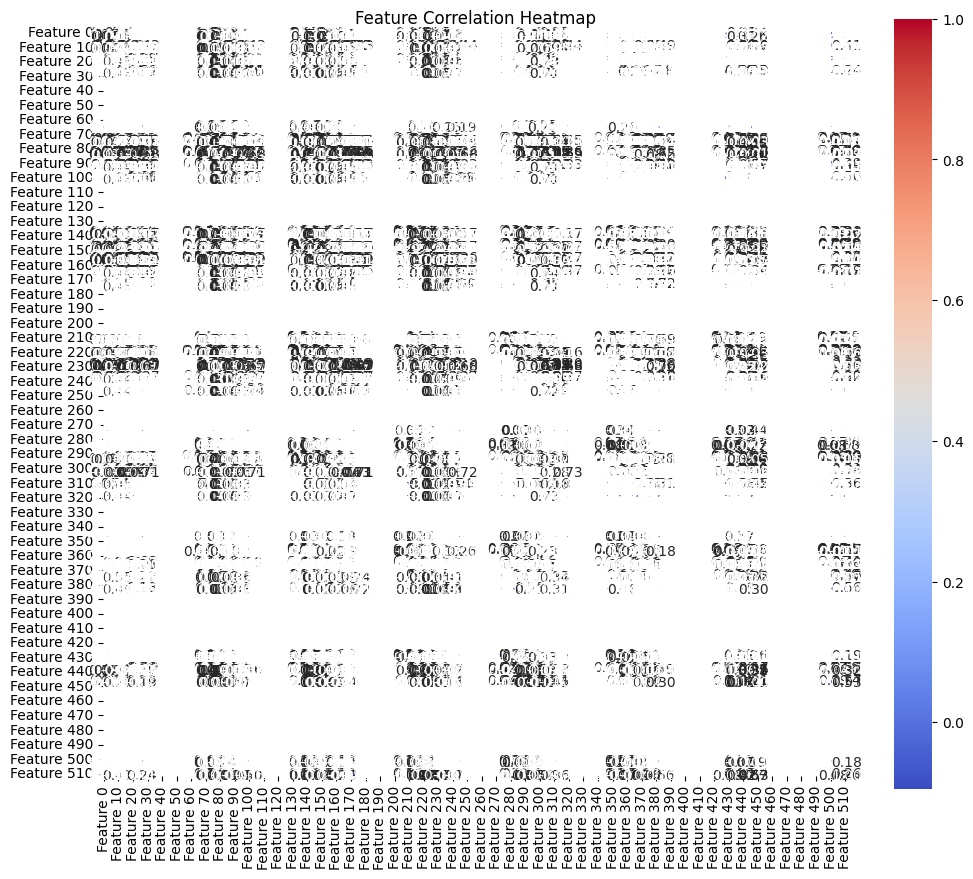

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for the features
feature_names = [f'Feature {i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame for the features
feature_names = [f'Feature {i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['Class'] = y

# Plot histograms for each feature
num_features = X.shape[1]
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    sns.histplot(data=df, x=feature, hue='Class', multiple='stack', ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Class')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for the features
feature_names = [f'Feature {i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['Class'] = y

# Plot box plots for each feature
num_features = X.shape[1]
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    sns.boxplot(data=df, x='Class', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Class')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import cv2
video_path = 'nakawa.avi'
cap = cv2.VideoCapture(video_path)
frame_count = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        cv2.imwrite(f'frames/frame_{frame_count:05d}.jpg', frame)
        frame_count += 1
    else:
        break
cap.release()
cv2.destroyAllWindows()

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your dataset if you have a CSV or similar file
# df = pd.read_csv('path_to_your_dataset.csv')

# Assuming X and y are your features and labels


In [19]:
# Create a DataFrame for features and labels
df = pd.DataFrame(X)
df['class'] = y

# Display the first few rows
print(df.head())

# Summary statistics
print(df.describe())

# Data types and missing values
print(df.info())

# Check class distribution
print(df['class'].value_counts())




     0    1    2    3    4    5    6    7    8     9  ...  503  504  505  506  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0  ...  0.0  0.0  0.0  0.0   
1  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.0  50.0  ...  0.0  0.0  0.0  0.0   
2  3.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  44.0  ...  0.0  0.0  0.0  0.0   
3  6.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  31.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0  ...  0.0  0.0  0.0  0.0   

   507  508  509  510    511  class  
0  0.0  0.0  0.0  0.0   48.0      2  
1  0.0  0.0  0.0  0.0    0.0      1  
2  0.0  0.0  0.0  0.0   83.0      2  
3  0.0  0.0  0.0  0.0  140.0      2  
4  0.0  0.0  0.0  0.0    0.0      1  

[5 rows x 513 columns]
                0           1           2           3      4      5      6  \
count  146.000000  146.000000  146.000000  146.000000  146.0  146.0  146.0   
mean     1.842466    1.616438    0.082192    0.006849    0.0    0.0    0.0   
std     13.109453   10.5256

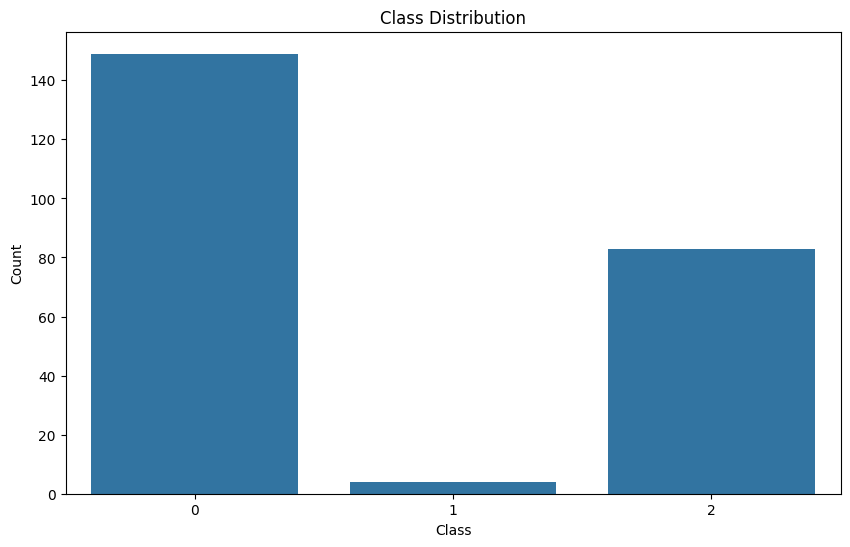

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


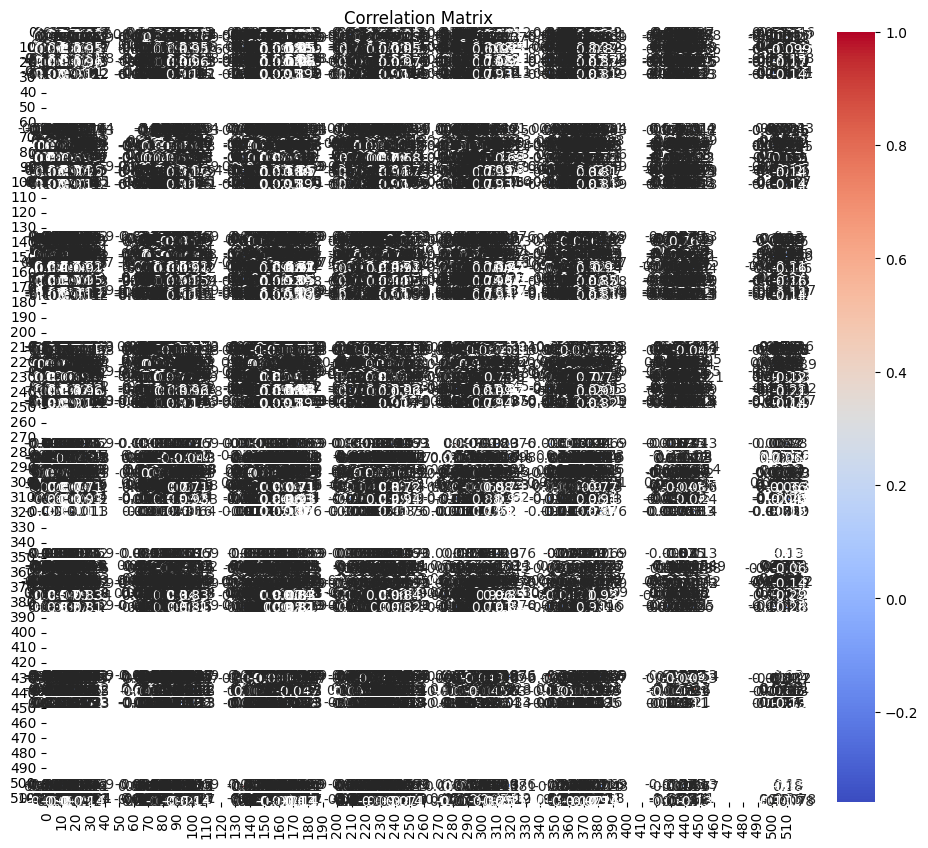

In [22]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



In [ ]:
sns.pairplot(df, hue='class')
plt.show()
